# Load Modules and File Paths

In [6]:
# ----------------- #
# Suppress Warnings #
# ----------------- #

import warnings
warnings.simplefilter("ignore") 

# ----------------- #
# IMPORT STUFF      #
# ----------------- #

import os
import sys
from os.path import abspath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams['text.latex.unicode']=False
import xarray as xr
import numpy as np
import richdem as rd
import joblib


if abspath('../../utils/') not in sys.path:
    sys.path.append(abspath('../../utils/'))
from utils import GetExtent, ventana

In [8]:
SITENAME = 'tuolumne'
name = 'snowdepth'
formato = 'tifs'
YEAR = '2015'
path_to_data = abspath(f'../../data/{formato}/{YEAR}')
path_to_topo = abspath('../../data/topo.nc')
files = os.listdir(path_to_data)
files = np.sort([f for f in files if 'int' in f])
fname_list = [os.path.join(path_to_data, f) for f in np.sort(files)]
dates = [d.split('_')[0] for d in files]
dates = np.sort(dates).tolist()
# dates = [pd.to_datetime(d.split('_')[0]).date() for d in files]

FileNotFoundError: [Errno 2] No such file or directory: '/home/jgongora/geohackweek/ghw2019_deepstac/data/netcdf/2015'

#### Dates of Acquisition
```
2015-02-18 
2015-03-06 
2015-03-25 
2015-04-03 
2015-04-09 
2015-04-15 
2015-04-27 
2015-05-01 
2015-05-28 
2015-06-08
```

### Read in Lidar and Topo Data Using Xarray

In [3]:
# --------------- #
# Read Lidar Data #
# --------------- #
ds = xr.open_mfdataset(fname_list, concat_dim='flight_date', chunks={'x':1000, 'y':1000})
ds.close()

dtopo = xr.open_dataset(path_to_topo, chunks={'x':1000, 'y':1000})
dtopo.close()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)


## Sub select features to include to the dem. 

In [5]:
add_to_lidar = ['dem','veg_height','mask']
dtopo = dtopo[add_to_lidar]

# --------------------- #
# Remove those features #
# --------------------- #

ds = ds.drop('transverse_mercator')

dtopo = dtopo.expand_dims('flight_date')

### Print Data Details

In [6]:
print('TOPO: \n\n',dtopo, '\n\n\nLidar:\n\n', ds)

TOPO: 

 <xarray.Dataset>
Dimensions:     (flight_date: 1, x: 17569, y: 17002)
Coordinates:
  * x           (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y           (y) float32 4230327.0 4230324.0 ... 4179327.0 4179324.0
Dimensions without coordinates: flight_date
Data variables:
    dem         (flight_date, y, x) float32 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
    veg_height  (flight_date, y, x) float32 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
    mask        (flight_date, y, x) uint8 dask.array<shape=(1, 17002, 17569), chunksize=(1, 1000, 1000)>
Attributes:
    last_modified:       [2019-08-08 17:17:16] Data added or updated
    Conventions:         CF-1.6
    dateCreated:         2019-08-08 17:17:34
    Title:               Topographic Images for SMRF/AWSM
    history:             [2019-08-08 17:17:34] Create netCDF4 file using Basi...
    institution:         USDA Agricultural Research Service, Northwest Waters...
  

### Trying to Add Date

In [11]:
ds['date'] = (['date'], dates)
ds = ds.assign_coords(date=ds.date)

datos = {}

datos['snowdepth'] = np.divide(ds.Band1[0,:,:].values,100)
datos['vegh'] = dtopo.veg_height.values.squeeze(axis=0)
datos['dem'] = dtopo.dem.values.squeeze(axis=0)

print(type(datos['dem']))
print(datos['dem'].shape)

## Generate Topographic Features from DEM

In [12]:
datos['dem'] = rd.rdarray(datos['dem'], no_data=-9999)

datos['slope'] = rd.TerrainAttribute(
    rd.rdarray(datos['dem'], no_data=-9999),
    attrib='slope_riserun'
)
datos['aspect'] = rd.TerrainAttribute(
    rd.rdarray(datos['dem'], no_data=-9999), 
    attrib='aspect')

datos['curvature'] = rd.TerrainAttribute(
    rd.rdarray(datos['dem'], no_data=-9999), 
    attrib='profile_curvature'
)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


### Visualize Features

### Stack all the input features & reshape & dump save for future reference.

In [15]:
FEATURES = ['dem', 'vegh', 'slope', 'aspect', 'curvature']
for f in FEATURES:
    datos[f] = np.expand_dims(np.array(datos[f]), axis=-1)
    

for llave, d in datos.items():
    print(llave, d.shape)

X = np.stack([d for llave, d in datos.items() if llave is not 'snowdepth'], axis=-1)
Y = datos['snowdepth']
print(datos.keys())
joblib.dump(datos, '../../processed/datos.joblib')

### Load Pre-Processed Data if Kernel Died.

In [6]:
# datos = joblib.load('../../processed/datos.joblib')  

# Plot the Features

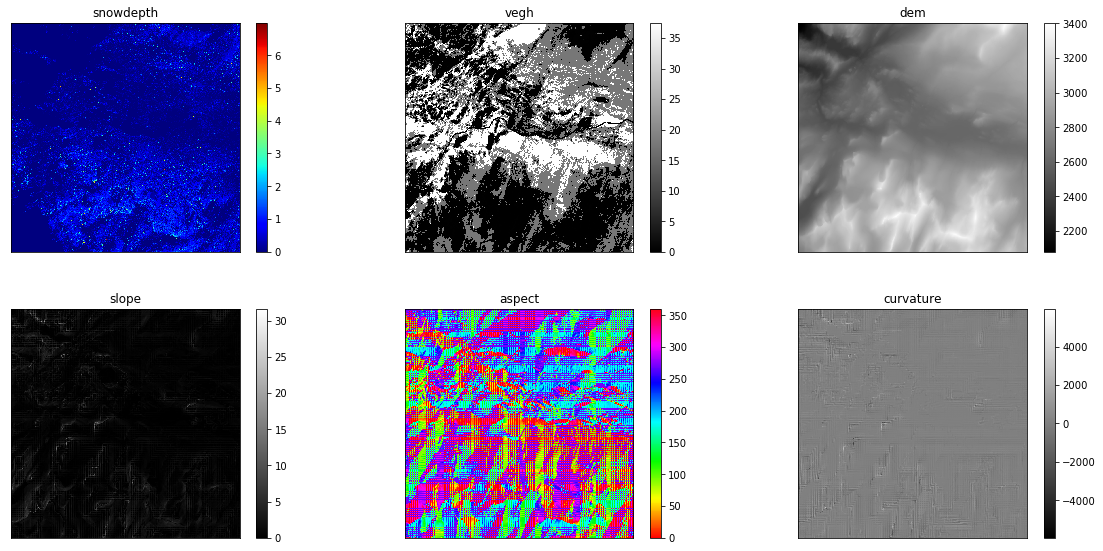

In [52]:
ix = 0
plt.figure(figsize=(20,20))
tmp = {}
for llave, data in datos.items():
    plt.subplot(4,3,ix+1)
    if llave not in ['UTME', 'UTMN']:
        if llave == 'aspect':
            cmap = 'hsv'
        elif llave == 'snowdepth':
            cmap = 'jet'
        else:
            cmap = 'gray'
        if llave == 'snowdepth':
            tmp[llave] = np.flipud(data)[
                image_size[0]:image_size[1], image_size[0]:image_size[1]
            ]
        else:
            tmp[llave] = data[
                image_size[0]:image_size[1], image_size[0]:image_size[1]
            ].squeeze(axis=-1) 
        plt.imshow(
            tmp[llave],
            cmap=cmap
        )
        plt.title(llave)
        if ix < 11:
            plt.gca().axes.get_yaxis().set_visible(False)
            plt.gca().axes.get_xaxis().set_visible(False)
        else:
            plt.xlabel('UTME')
            plt.ylabel('UTMN')
        cbar = plt.colorbar()
        plt.subplots_adjust(left=None, bottom=None, right=None, wspace=None, hspace=0.25)
        ix = ix + 1

In [53]:
joblib.dump(tmp, '../../processed/subset_datos.joblib')

['../../processed/subset_datos.joblib']